### Weakly singular $\iint _T g(\vec{r},\vec{r}') \nabla \cdot \Lambda _1 ^T (\vec{r}') \, dr'$

### Strongly singular $\iint _T \nabla g(\vec{r},\vec{r}') \nabla \cdot \Lambda _1 ^T (\vec{r}') \, dr'$

$\Lambda_1^E \left(\begin{bmatrix} x\\y \\0\end{bmatrix}\right) = \begin{bmatrix}x \\y \\0 \end{bmatrix}$

In [1]:
import numpy, scipy, pandas, itertools
import matplotlib.pyplot as plt

# side-by side display of pandas data frames
from IPython.display import display, HTML
CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

In [2]:
# define the Triangle element class with methods

class Triangle:
    def __init__(self,a,b,c):

        # initialize the vertices
        self.a = numpy.array(a)
        self.b = numpy.array(b)
        self.c = numpy.array(c)
        
        # define the Jacobian and its inverse
        self._col1 = self.a - self.c
        self._col2 = self.b - self.c
        self._col3 = numpy.cross(self._col1,self._col2)/numpy.linalg.norm(numpy.cross(self._col1,self._col2))
        self.Jac = numpy.array([self._col1,self._col2,self._col3]).T
        self.JacInv = numpy.linalg.inv(self.Jac)
        self.J = numpy.linalg.norm(numpy.cross(self._col1,self._col2))
        
        self.area = self.J/2.
        
        # initialize the quadrature points
        self.qp = []
        self.n = 0
        
    # get map from reference to this triangle
    def refToPhys(self,point):
        return numpy.dot(self.Jac, numpy.array([point[0],point[1],0])) + self.c
    
    # plot the triangle
    def plotElement(self):
        from mpl_toolkits.mplot3d import Axes3D
        import matplotlib.pyplot as plt
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        ax.scatter(*self.a)
        ax.scatter(*self.b)
        ax.scatter(*self.c)
        #from mpl_toolkits.mplot3d.art3d import Poly3DCollection
        #poly3d = [1,0,0]
        #ax.add_collection3d(Poly3DCollection(poly3d, facecolors=['blue'], linewidths=1))
        plt.show()

    def setUniformQP(self,n):
        self.n = n
        refQP = [numpy.array([j+0.5,n+.5-i],float)/n for i in range(n+1) for j in range(i)]
        self.qp = [self.refToPhys(point) for point in refQP]
        return len(self.qp)
        
    def plotQP(self):
        from mpl_toolkits.mplot3d import Axes3D
        import matplotlib.pyplot as plt
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        [ax.scatter(*point) for point in self.qp]
        plt.show()
        
    def coordsDuffy(self,t):
        t1 = t[0]
        t2 = t[1]
        return numpy.array((1.-(t1+1.)/2.)*self.c + \
                           (t1+1.)/2. * (1.- (t2+1.)/2.)*self.a + \
                           (t1+1.)*(t2+1.)*self.b/4.)

In [3]:
# kernels

# weakly singular
def g(r,rp,k=1):
    R = numpy.linalg.norm(numpy.array(r)-numpy.array(rp))
    return numpy.exp(-1j*k*R)/(4*numpy.pi*R)

# strongly singular, coordinate-wise
def gradgx(r,rp,k=1):
    R = numpy.linalg.norm(numpy.array(r)-numpy.array(rp))
    return (r[0]-rp[0]) * numpy.exp(-1j*R)*(-1j*k*R - 1.)/numpy.power(R,3)

def gradgy(r,rp,k=1):
    R = numpy.linalg.norm(numpy.array(r)-numpy.array(rp))
    return (r[1]-rp[1]) * numpy.exp(-1j*R)*(-1j*k*R - 1.)/numpy.power(R,3)

def gradgz(r,rp,k=1):
    R = numpy.linalg.norm(numpy.array(r)-numpy.array(rp))
    return (r[2]-rp[2]) * numpy.exp(-1j*R)*(-1j*k*R - 1.)/numpy.power(R,3)

In [4]:
# integrate g(r,r')*div(\Lambda_1) via uniform midpoint rule
def approxUniform(T,g,rp,n,k=1):
    T.setUniformQP(n)
    value = 0.0
    for point in T.qp:
        testA = point - T.a
        testB = point - T.b
        testA = testA/numpy.linalg.norm(testA)
        testB = testB/numpy.linalg.norm(testB)
        weight = 0.0
        if numpy.dot(testA,testB) == 1. or numpy.dot(testA,testB) == -1.:
            weight = 2.*n*n
        else:
            weight = n*n
        value += g(point,rp,k)*\
            (T.JacInv[0][0]*T.Jac[0][0] + T.JacInv[1][0]*T.Jac[0][1] + \
             T.JacInv[0][1]*T.Jac[1][0] + T.JacInv[1][1]*T.Jac[1][1])*\
            T.J/weight
            #(T.JacInv[0][0]*T.Jac[0][0] + T.JacInv[1][0]*T.Jac[0][1] + T.JacInv[2][0]*T.Jac[0][2] + \
            # T.JacInv[0][1]*T.Jac[1][0] + T.JacInv[1][1]*T.Jac[1][1] + T.JacInv[2][1]*T.Jac[1][2])*\
            #T.J/weight
    return value

# Duffy transform approximation
def approxDuffy(T,g,rp,n,k=1):
    # determine quadrature rule for Duffy transform in the (t1,t2) coordinates
    value = 0.0
    tQP = [i for i in itertools.product(numpy.polynomial.legendre.leggauss(n)[0],\
                                            numpy.polynomial.legendre.leggauss(n)[0])]
    tW = [i for i in itertools.product(numpy.polynomial.legendre.leggauss(n)[1],\
                                            numpy.polynomial.legendre.leggauss(n)[1])]
    D1 = Triangle(rp,T.a,T.b)
    D2 = Triangle(rp,T.b,T.c)
    D3 = Triangle(rp,T.c,T.a)
    for D in [D1, D2, D3]:
        for i in range(len(tQP)):
            t1, t2 = tQP[i]
            tensorweight = tW[i][0]*tW[i][1]
            value += g(D.coordsDuffy([t1,t2]),rp,k)*\
                (T.JacInv[0][0]*T.Jac[0][0] + T.JacInv[1][0]*T.Jac[0][1] + \
                 T.JacInv[0][1]*T.Jac[1][0] + T.JacInv[1][1]*T.Jac[1][1])*\
                (t1+1.)/4.*D.area * tensorweight
                #(T.JacInv[0][0]*T.Jac[0][0] + T.JacInv[1][0]*T.Jac[0][1] + T.JacInv[2][0]*T.Jac[0][2] + \
                # T.JacInv[0][1]*T.Jac[1][0] + T.JacInv[1][1]*T.Jac[1][1] + T.JacInv[2][1]*T.Jac[1][2])*\
                #(t1+1.)/4.*D.area * tensorweight
    return  value

In [5]:
# Duffy transform and singularity extraction approximation
def approxDuffySingEx(T,g,rp,n,k=1):
    dxp_dt1 = lambda (t1,t2) = 
    dyp_dt1 = lambda (t1,t2) = 
    dzp_dt1 = lambda (t1,t2) = 
    fkcubed = lambda t2 = numpy.power(numpy.power(dxp_dt1((-1,t2)),2)+\
                                      numpy.power(dyp_dt1((-1,t2)),2)+\
                                      numpy.power(dzp_dt1((-1,t2)),2),0.5)
    # regular part
    # determine quadrature rule for Duffy transform in the (t1,t2) coordinates
    value = 0.0
    tQP = [i for i in itertools.product(numpy.polynomial.legendre.leggauss(n)[0],\
                                            numpy.polynomial.legendre.leggauss(n)[0])]
    tW = [i for i in itertools.product(numpy.polynomial.legendre.leggauss(n)[1],\
                                            numpy.polynomial.legendre.leggauss(n)[1])]
    D1 = Triangle(rp,T.a,T.b)
    D2 = Triangle(rp,T.b,T.c)
    D3 = Triangle(rp,T.c,T.a)
    for D in [D1, D2, D3]:
        for i in range(len(tQP)):
            t1, t2 = tQP[i]
            tensorweight = tW[i][0]*tW[i][1]
            value += D.area * 1./(16.*numpy.pi)*\
                ((1./t1+1 fkcubed(t2))*dxp_dt1(-1,t2) - g(D.coordsDuffy([t1,t2]),rp,k))*\
                (T.JacInv[0][0]*T.Jac[0][0] + T.JacInv[1][0]*T.Jac[0][1] + \
                 T.JacInv[0][1]*T.Jac[1][0] + T.JacInv[1][1]*T.Jac[1][1])*\
                T.J*tensorweight
    # singular part
    for D in [D1, D2, D3]:
        value += -1./(16.*numpy.pi)*
    return value

SyntaxError: invalid syntax (<ipython-input-5-2e05a19b6207>, line 3)

In [6]:
# test the Duffy transform
A = (1,1,5)
B = (0,2,5)
C = (0,1,5)
T = Triangle(A,B,C)

print '(-1,-1) got mapped to',T.coordsDuffy((-1,-1))
print '(-1, 0) got mapped to',T.coordsDuffy((-1,0))
print '(-1,+1) got mapped to',T.coordsDuffy((-1,1))

print '(+1,-1) got mapped to',T.coordsDuffy((1,-1))
print '(+1, 0) got mapped to',T.coordsDuffy((1,0))
print '(+1,+1) got mapped to',T.coordsDuffy((1,1))

print 'area is',T.area

(-1,-1) got mapped to [0. 1. 5.]
(-1, 0) got mapped to [0. 1. 5.]
(-1,+1) got mapped to [0. 1. 5.]
(+1,-1) got mapped to [1. 1. 5.]
(+1, 0) got mapped to [0.5 1.5 5. ]
(+1,+1) got mapped to [0. 2. 5.]
area is 0.5


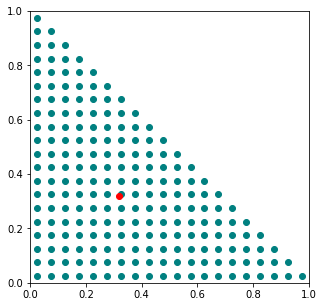

In [7]:
%matplotlib inline
A = (1,0,0)
B = (0,1,0)
C = (0,0,0)
T = Triangle(A,B,C)
rp = T.refToPhys((1./numpy.pi , 1/numpy.pi))

T.setUniformQP(20)
plt.figure(figsize=(5,5))
for point in T.qp:
    plt.scatter(point[0],point[1],color='teal')
plt.scatter(rp[0],rp[1],color='red')
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

### Weakly singular $\iint _T g(\vec{r},\vec{r}') \nabla \cdot \Lambda _1 ^T (\vec{r}') \, dr'$

#### test under translation and rotation

In [8]:
# apply the uniform midpoint rule for approximation
A = (1,0,0)
B = (0,1,0)
C = (0,0,0)
T = Triangle(A,B,C)
rp = T.refToPhys((1./numpy.pi , 1/numpy.pi))
maxLevel = 20
steps = 15

results = [approxUniform(T,g,rp,int(i)) for i in numpy.linspace(1,maxLevel,steps)]
dataUniform = pandas.DataFrame([numpy.real(results),numpy.imag(results)]).T
dataUniform.columns = ['Unif Real', 'Unif Imag']
dataUniform.index = [len([numpy.array([j+0.5,int(n)+.5-i],float)/int(n) for i in range(int(n)+1) for j in range(i)]) for n in numpy.linspace(1,maxLevel,steps)]

In [9]:
# check the result under the translation y+=1, z+=5
A = (1,1,5)
B = (0,2,5)
C = (0,1,5)
T = Triangle(A,B,C)
rp = T.refToPhys((1./numpy.pi , 1/numpy.pi))
maxLevel = 20
steps = 15

results = [approxUniform(T,g,rp,int(i)) for i in numpy.linspace(1,maxLevel,steps)]
dataUniformTest1 = pandas.DataFrame([numpy.real(results),numpy.imag(results)]).T
dataUniformTest1.columns = ['Unif Real', 'Unif Imag']
dataUniformTest1.index = [len([numpy.array([j+0.5,int(n)+.5-i],float)/int(n) for i in range(int(n)+1) for j in range(i)]) for n in numpy.linspace(1,maxLevel,steps)]

In [10]:
# check the result under a rotation
A = (0,0,1)
B = (0,1,0)
C = (0,0,0)
T = Triangle(A,B,C)
rp = T.refToPhys((1./numpy.pi , 1/numpy.pi))
maxLevel = 20
steps = 15

results = [approxUniform(T,g,rp,int(i)) for i in numpy.linspace(1,maxLevel,steps)]
dataUniformTest2 = pandas.DataFrame([numpy.real(results),numpy.imag(results)]).T
dataUniformTest2.columns = ['Unif Real', 'Unif Imag']
dataUniformTest2.index = [len([numpy.array([j+0.5,int(n)+.5-i],float)/int(n) for i in range(int(n)+1) for j in range(i)]) for n in numpy.linspace(1,maxLevel,steps)]

In [11]:
display(dataUniform)
display(dataUniformTest1)
display(dataUniformTest2)

,Unif Real,Unif Imag
1,0.599069,-0.157409
3,0.492430,-0.078261
6,0.320719,-0.086924
15,0.507699,-0.081285
21,0.331624,-0.078129
28,0.365439,-0.082922
45,0.352722,-0.080909
55,0.352150,-0.078119
66,7.588425,-0.082522
91,0.362982,-0.081313


,Unif Real,Unif Imag
1,0.599069,-0.157409
3,0.492430,-0.078261
6,0.334871,-0.095347
15,0.519594,-0.087373
21,0.334376,-0.080191
28,0.362685,-0.082836
45,0.357410,-0.082813
55,0.357561,-0.080416
66,7.590654,-0.083194
91,0.360715,-0.080405


,Unif Real,Unif Imag
1,0.299534,-0.078705
3,0.246215,-0.039130
6,0.160359,-0.043462
15,0.253850,-0.040642
21,0.165812,-0.039065
28,0.182719,-0.041461
45,0.176361,-0.040455
55,0.176075,-0.039059
66,3.794213,-0.041261
91,0.181491,-0.040656


#### compare midpoint uniform approx to Duffy transform approximation

In [12]:
# apply the uniform midpoint rule for approximation
A = (.1,0,0)
B = (0,.13,0)
C = (0,0,.2)
T = Triangle(A,B,C)
rp = T.refToPhys((1./numpy.pi , 1/numpy.pi))
maxLevel = 400
steps = 15

results = [approxUniform(T,g,rp,int(i)) for i in numpy.linspace(1,maxLevel,steps)]
dataUniform = pandas.DataFrame([numpy.real(results),numpy.imag(results)]).T
dataUniform.columns = ['Unif Real', 'Unif Imag']
dataUniform.index = [len([numpy.array([j+0.5,int(n)+.5-i],float)/int(n) for i in range(int(n)+1) for j in range(i)]) for n in numpy.linspace(1,maxLevel,steps)]

In [13]:
# apply the Duffy transform for approximation
A = (.1,0,0)
B = (0,.13,0)
C = (0,0,.2)
T = Triangle(A,B,C)
rp = T.refToPhys((1./numpy.pi , 1/numpy.pi))
maxLevel = 30
steps = 15

results = [approxDuffy(T,g,rp,int(i)) for i in numpy.linspace(2,maxLevel,steps)]
dataDuffy = pandas.DataFrame([numpy.real(results),numpy.imag(results)]).T
dataDuffy.columns = ['Duffy Real', 'Duffy Imag']
dataDuffy.index = [3*len(numpy.polynomial.legendre.leggauss(int(i))[0])**2 for i in numpy.linspace(1,maxLevel,steps)]

In [14]:
display(dataUniform)
display(dataDuffy)

,Unif Real,Unif Imag
1,0.020237,-0.001593
435,0.040021,-0.001601
1711,0.043182,-0.001601
3741,0.040854,-0.001596
6670,0.040953,-0.001596
10296,0.043267,-0.001596
14878,0.040745,-0.001595
20100,0.040814,-0.001595
26335,0.040812,-0.001595
33153,0.040791,-0.001595


,Duffy Real,Duffy Imag
3,0.041343,-0.001594
27,0.041491,-0.001594
75,0.041239,-0.001594
147,0.041106,-0.001594
243,0.041033,-0.001594
363,0.040990,-0.001594
507,0.040963,-0.001594
675,0.040945,-0.001594
867,0.040932,-0.001594
1083,0.040923,-0.001594


#### performance profiling

In [16]:
# that required this many quadrature points
n=20 # for uniform
print 'unif  approx:',len([numpy.array([j+0.5,int(n)+.5-i],float)/int(n) for i in range(int(n)+1) for j in range(i)]),\
    'with approx value', approxUniform(T,g,rp,n)
n = 8 # for Duffy
print 'Duffy approx:',3*len(numpy.polynomial.legendre.leggauss(int(n))[0])**2,\
    'with approx value', approxDuffy(T,g,rp,n)

unif  approx: 210 with approx value (0.040508300100666673-0.0015974813526198296j)
Duffy approx: 192 with approx value (0.0411063125708207-0.0015935026848723805j)


In [17]:
%%timeit
n=20
approxUniform(T,g,rp,n)

100 loops, best of 3: 4.81 ms per loop


In [18]:
%%timeit
n=8
approxDuffy(T,g,rp,n)

100 loops, best of 3: 4.21 ms per loop


### Strongly singular $\iint _T \nabla g(\vec{r},\vec{r}') \nabla \cdot \Lambda _1 ^T (\vec{r}') \, dr'$

In [29]:
A = (0.20,0,0)
B = (0,0.21,0)
C = (0,0,0.23)
T = Triangle(A,B,C)
rp = T.refToPhys((1./numpy.pi , 1/numpy.pi))

freqHz     = 30e6;
eps0       = 8.85418781761e-12;
mu0        = numpy.pi*4e-7;
c_light    = 1./numpy.sqrt(eps0*mu0);
wavelength = c_light/freqHz;
#eta        = numpy.sqrt(mu0/eps0);
#omega      = 2*numpy.pi*freqHz;
k0         = 2.*numpy.pi/wavelength;

### x- component

In [30]:
# apply the uniform midpoint rule for approximation
maxLevel = 200
steps = 15
results = [approxUniform(T,gradgx,rp,int(i),k0) for i in numpy.linspace(1,maxLevel,steps)]
dataUniform = pandas.DataFrame([numpy.real(results),numpy.imag(results)]).T
dataUniform.columns = ['Unif Real', 'Unif Imag']
dataUniform.index = [len([numpy.array([j+0.5,int(n)+.5-i],float)/int(n) for i in range(int(n)+1) for j in range(i)]) for n in numpy.linspace(1,maxLevel,steps)]

In [31]:
# apply the Duffy transform for approximation

maxLevel = 100
steps = 15
results = [approxDuffy(T,gradgx,rp,int(i),k0) for i in numpy.linspace(2,maxLevel,steps)]
dataDuffy = pandas.DataFrame([numpy.real(results),numpy.imag(results)]).T
dataDuffy.columns = ['Duffy Real part', 'Duffy Imag']
dataDuffy.index = [3*len(numpy.polynomial.legendre.leggauss(int(i))[0])**2 for i in numpy.linspace(1,maxLevel,steps)]

In [32]:
# apply the Duffy transform and singularity extraction for approximation

maxLevel = 100
steps = 15
results = [approxDuffySingEx(T,gradgx,rp,int(i),k0) for i in numpy.linspace(2,maxLevel,steps)]
dataDuffySing = pandas.DataFrame([numpy.real(results),numpy.imag(results)]).T
dataDuffySing.columns = ['Duf & SingEx Real part', 'Duf & SingEx Imag']
dataDuffySing.index = [3*len(numpy.polynomial.legendre.leggauss(int(i))[0])**2 for i in numpy.linspace(1,maxLevel,steps)]

NameError: name 'approxDuffySingEx' is not defined

In [33]:
display(dataUniform)
display(dataDuffy)
display(dataDuffySing)

,Unif Real,Unif Imag
1,-3.817861,0.140404
120,0.242282,0.006089
435,-0.677112,0.006569
946,2.619927,0.003798
1653,0.319152,0.005396
2628,-0.709773,0.005826
3741,-7.642647,0.007423
5050,-0.436506,0.005592
6555,-1.987028,0.005970
8256,0.870420,0.005286


,Duffy Real part,Duffy Imag
3,0.285063,0.003088
192,0.648894,0.005030
675,0.671917,0.005283
1452,0.677192,0.005355
2523,0.679188,0.005384
3888,0.680156,0.005399
5547,0.680698,0.005407
7500,0.681032,0.005412
9747,0.681252,0.005416
12288,0.681406,0.005418


NameError: name 'dataDuffySing' is not defined

### y- component

In [ ]:
# apply the uniform midpoint rule for approximation
maxLevel = 200
steps=15
results = [approxUniform(T,gradgy,rp,int(i),k0) for i in numpy.linspace(1,maxLevel,steps)]
dataUniform = pandas.DataFrame([numpy.real(results),numpy.imag(results)]).T
dataUniform.columns = ['Unif Real', 'Unif Imag']
dataUniform.index = [len([numpy.array([j+0.5,int(n)+.5-i],float)/int(n) for i in range(int(n)+1) for j in range(i)]) for n in numpy.linspace(1,maxLevel,steps)]

# apply the Duffy transform for approximation
maxLevel = 100
steps=15
results = [approxDuffy(T,gradgy,rp,int(i),k0) for i in numpy.linspace(2,maxLevel,steps)]
dataDuffy = pandas.DataFrame([numpy.real(results),numpy.imag(results)]).T
dataDuffy.columns = ['Duffy Real part', 'Duffy Imag']
dataDuffy.index = [3*len(numpy.polynomial.legendre.leggauss(int(i))[0])**2 for i in numpy.linspace(1,maxLevel,steps)]

In [ ]:
display(dataUniform)
display(dataDuffy)

### z- component

In [ ]:
# apply the uniform midpoint rule for approximation
maxLevel = 200
steps=15
results = [approxUniform(T,gradgz,rp,int(i),k0) for i in numpy.linspace(1,maxLevel,steps)]
dataUniform = pandas.DataFrame([numpy.real(results),numpy.imag(results)]).T
dataUniform.columns = ['Unif Real', 'Unif Imag']
dataUniform.index = [len([numpy.array([j+0.5,int(n)+.5-i],float)/int(n) for i in range(int(n)+1) for j in range(i)]) for n in numpy.linspace(1,maxLevel,steps)]

# apply the Duffy transform for approximation
maxLevel = 100
steps=15
results = [approxDuffy(T,gradgz,rp,int(i),k0) for i in numpy.linspace(2,maxLevel,steps)]
dataDuffy = pandas.DataFrame([numpy.real(results),numpy.imag(results)]).T
dataDuffy.columns = ['Duffy Real', 'Duffy Imag']
dataDuffy.index = [3*len(numpy.polynomial.legendre.leggauss(int(i))[0])**2 for i in numpy.linspace(1,maxLevel,steps)]

In [ ]:
display(dataUniform)
display(dataDuffy)